In [4]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import tensorflow as tf

models_path = 'models_resnet/resnet_data_word_1.hdf5'
rgb = False
imageSize = 50

In [5]:
#load_dataset function to load the data and resize the images to 50x50
def load_dataset(directory):
  images = []
  labels = []
  for idx, label in enumerate(uniq_labels):
    for file in os.listdir(directory + '/'+label):
      filepath = directory +'/'+ label + "/" + file
      img = cv2.resize(cv2.imread(filepath),(50,50))
      images.append(img)
      labels.append(idx)
  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels#loading_dataset into X_pre and Y_pre


In [6]:
data_dir = r'../input/data-word/data_word'
uniq_labels = sorted(os.listdir(data_dir))
X_pre, Y_pre = load_dataset(data_dir)
print(X_pre.shape, Y_pre.shape)

(24015, 50, 50, 3) (24015,)


In [7]:
#display_images function to show examples
def display_images(x_data,y_data, title, display_label = True):
    x, y = x_data,y_data
    fig, axes = plt.subplots(5, 8, figsize = (18, 5))
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    fig.suptitle(title, fontsize = 18)
    for i, ax in enumerate(axes.flat):
        ax.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        if display_label:
            ax.set_xlabel(uniq_labels[y[i]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Total number of symbols:  15
Number of training images:  16810
Number of testing images:  3602
Number of evaluation images:  3603
---------------------------
Train images shape (16810, 50, 50, 3) (16810,)
Test images shape (3602, 50, 50, 3) (3602,)
Evaluate image shape (3603, 50, 50, 3) (3603,)
Printing the labels ['Bad', 'Deaf', 'Fine', 'Good', 'Goodbye', 'Hearing', 'Hello', 'How are you', 'Nice to meet you', 'Please', 'See you later', 'See you tomorrow', 'Sorry', 'Thank you', 'What is your name'] 15


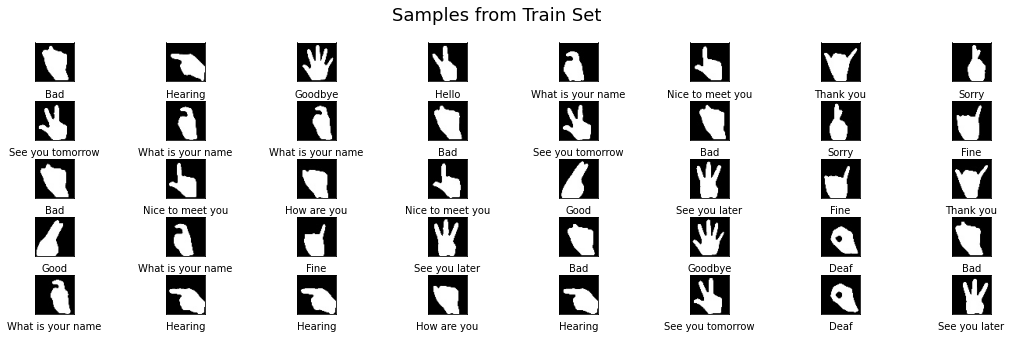

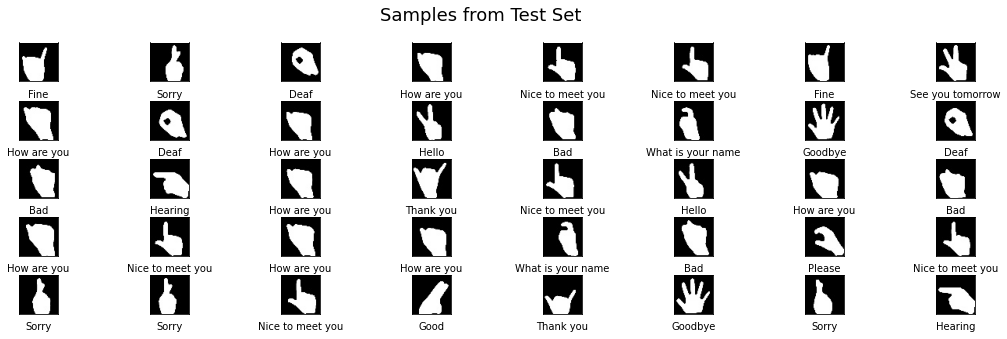

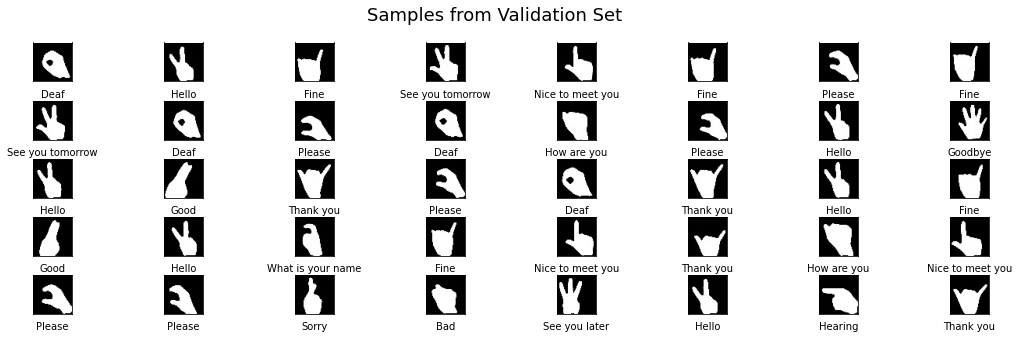

In [8]:
#spliting dataset into 80% train, 10% validation and 10% test data
X_train, X_test, y_train, y_test = train_test_split(X_pre, Y_pre, test_size = 0.3)
X_test, X_eval, y_test, y_eval = train_test_split(X_test, y_test, test_size = 0.5)


n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

print("---------------------------")

print("Train images shape",X_train.shape, y_train.shape)
print("Test images shape",X_test.shape, y_test.shape)
print("Evaluate image shape",X_eval.shape, y_eval.shape)
print("Printing the labels",uniq_labels, len(uniq_labels))

display_images(X_train,y_train,'Samples from Train Set')
display_images(X_test,y_test,'Samples from Test Set')
display_images(X_eval,y_eval,'Samples from Validation Set')


In [9]:
# import keras
# import keras.utils
# from keras import utils as np_utils
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)
y_eval = keras.utils.np_utils.to_categorical(y_eval)
# 
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [10]:

# Dat cac checkpoint de luu lai model tot nhat

model_checkpoint = ModelCheckpoint(filepath=models_path, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

# Khoi tao model
imageSize = 50
model2 = ResNet50( 
    include_top=False,
    weights='imagenet',
    input_shape=(imageSize, imageSize, 3))
optimizer2 = tf.optimizers.Adam()
base_model2 = model2

# Them cac lop ben tren

x = base_model2.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
# x = Dense(128, activation='relu', name='fc2a')(x)
x = Dense(64, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', name='fc4')(x)

predictions = Dense(15, activation='softmax')(x)
model3 = Model(inputs=base_model2.input, outputs=predictions)

# Dong bang cac lop duoi, chi train lop ben tren minh them vao
for layer in base_model2.layers:
    layer.trainable = False

# 12epouchs
# opt1 = tf.keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(optimizer= "Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()
history = model3.fit(X_train, y_train, epochs=60, batch_size=30, validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping, model_checkpoint])


94781440/94765736 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
_____________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
561/561 [==============================] - 10s 19ms/step - loss: 0.0748 - accuracy: 0.9742 - val_loss: 0.0031 - val_accuracy: 0.9989
Epoch 3/60
561/561 [==============================] - 10s 18ms/step - loss: 0.0363 - accuracy: 0.9882 - val_loss: 8.0077e-04 - val_accuracy: 0.9997
Epoch 4/60
561/561 [==============================] - 10s 18ms/step - loss: 0.0396 - accuracy: 0.9877 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 5/60
561/561 [==============================] - 10s 18ms/step - loss: 0.0206 - accuracy: 0.9930 - val_loss: 2.8527e-04 - val_accuracy: 1.0000
Epoch 6/60
561/561 [==============================] - 10s 18ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.0264 - val_accuracy: 0.9914
Epoch 7/60
561/561 [==============================] - 10s 18ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 9.6978e-06 - val_accuracy: 1.0000
Epoch 8/60
561/561 [==============================] - 10s 19ms/step - loss: 0.0287 - accuracy: 0.9921 - val_loss: 0.0244 - v

In [11]:
score = model3.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model3.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 100.0 %


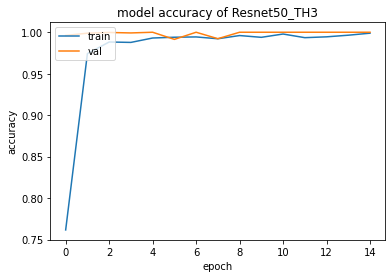

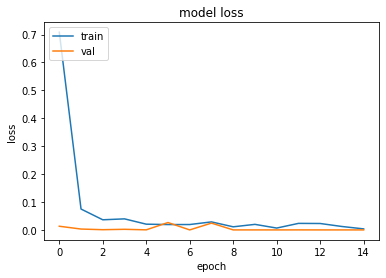

In [12]:
#resnet50
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of Resnet50_TH3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import classification_report
# y_true = y_test
# y_pred =  y_test_pred

y_pred=model3.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
y_true=np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names = uniq_labels))

                   precision    recall  f1-score   support

              Bad       1.00      1.00      1.00       246
             Deaf       1.00      1.00      1.00       257
             Fine       1.00      1.00      1.00       241
             Good       1.00      1.00      1.00       212
          Goodbye       1.00      1.00      1.00       262
          Hearing       1.00      1.00      1.00       239
            Hello       1.00      1.00      1.00       245
      How are you       1.00      1.00      1.00       245
 Nice to meet you       1.00      1.00      1.00       247
           Please       1.00      1.00      1.00       249
    See you later       1.00      1.00      1.00       205
 See you tomorrow       1.00      1.00      1.00       222
            Sorry       1.00      1.00      1.00       231
        Thank you       1.00      1.00      1.00       268
What is your name       1.00      1.00      1.00       233

         accuracy                           1.00      